# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [4]:
import torch
import torch.nn as nn # Model을 구성하는 연산(Layer)
from torch.utils.data import DataLoader # DataLoader 클래스. 
from torchvision import datasets, transforms
# torchvision: 파이토치에서 영상데이터 처리를 위한 기능들을 제공하는 패키지(Lib).
import matplotlib.pyplot as plt

print("파이토치버전:",  torch.__version__)

파이토치버전: 2.3.0+cpu


### device 설정

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#mac, m1, m2
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'cpu'

### 하이퍼파라미터, 변수 설정

In [6]:
# 학습률 - 파라미터 update시 gradient의 어느정도 비율을 적용할지 곱해줄 값.
#             optimizer에 적용.
lr = 0.001  
batch_size = 256 
# 한번 학습할 때(step-파라미터 업데이트 단위.) 몇개의 데이터를 모델에 주입(feed)할지 개수.
epochs = 20
# 학습 데이터 셋을 전체를 한번 학습하는 것을 epoch이라고 한다.

In [7]:
# 변수
import os
dataset_path = r"c:\classes\deeplearning\datasets" # 데이터셋 저장할 디렉토리.
os.makedirs(dataset_path, exist_ok=True)
model_path =  r"c:\classes\deeplearning\saved_models\mnist" # 모델 저장할 디렉토리 
os.makedirs(model_path, exist_ok=True)

### MNIST dataset Loading
#### Dataset

In [9]:
# torchvision에서 제공하는 mnist dataset을 다운 및 loading
trainset = datasets.MNIST(
    root=dataset_path, # 다운 받은 데이터셋을 저장할 디렉토리.(있으면 다운 안받음.)
    download=True,    # root에 다운받은 파일이 없으면 download 할지 여부.
    transform=transforms.ToTensor(), # 데이터 전처리 함수를 가진 객체.
)
testset = datasets.MNIST(
    root=dataset_path, 
    train=False,  # train과 test set중 어떤 것을 사용할 지 여부: True(default)-trainset, False-testset
    download=True, 
    transform=transforms.ToTensor()
)
# ToTensor() - 원본 이미지(raw)가 ndarray거나 PIL.Image 타입인 것을 torch.Tensor로
##                변환. (height, width, channel) -> (channel, height, width)
##                 픽셀(화소)값들을 0 ~ 1 정규화 한다.

#### DataLoader

In [55]:
torch.randperm(10) 

tensor([8, 0, 2, 3, 7, 6, 4, 5, 1, 9])

In [56]:
# Dataset을 넣어서 DataLoader를 생성 
## Dataset은 데이터를 하나씩 loading 역할.
## DataLoader는 데이터를 batch단위로 모델에 제공하는 역할.
train_loader = DataLoader(
    trainset, # Dataset
    batch_size=batch_size,
    shuffle=True, # 데이터 제공 epoch이 시작할 때 섞을지(shuffle)여부(default: False)
    drop_last=True, # 마지막 batch의 개수가 batch_size보다 적으면 학습하지 않게한다.
    generator=torch.Generator(device=device)
)
test_loader = DataLoader(
    testset, # Dataset
    batch_size=batch_size,
    generator=torch.Generator(device=device)
)
# 검증/최종 평가 데이터세의 dataloader -> shuffle, drop_last는 설정안함.
###  batch_size가 train_loader와 달라도 상관없다.


In [57]:
print("Trainset의 1 epoch당 step수:", len(train_loader))
print("Testset의 1 epoch당 step수:", len(test_loader))

# 1 epoch당 step수: Dataset 전체를 한번 학습할 때 몇번 파라미터들을 update하는지.

Trainset의 1 epoch당 step수: 234
Testset의 1 epoch당 step수: 40


In [58]:
# 총 데이터 개수
len(trainset), len(testset)

(60000, 10000)

### 모델 정의

In [62]:
# 28 * 28  (mnist 이미지 size) => feature: 개별 화소(pixcel)

In [70]:
class MNISTModel(nn.Module):
    def __init__(self):
        """모델이 추론하는데 필요한 자원(Layer등등)들을 생성 및 초기화한다.
        """
        # 1. super class(nn.Module)의 __init__()을 호출해서 초기화.
        super().__init__() 
        # 2. 이 모델에서 필요한 자원들 초기화.
        self.lr1 = nn.Linear(784, 128) # (입력: 784-이미지화소수, 출력: 128)
        self.lr2 = nn.Linear(128, 64)   # (입력: 128-lr1의 출력개수, 출력: 64)
        self.lr3 = nn.Linear(64, 10)    # (입력: 64-lr2의 출력개수, 출력-10: target(y)의 class개수.)
        # 784: 입력 feature수, 10: 출력 class의 개수
        # 128, 64 -> hyper parameter(우리가 정한 값.)

    def forward(self, X):
        """X를 입력받아서 y를 추정하는 계산을 정의.
        X를 입력받아서 그 결과를 최종 출력 할 때 까지의 계산 흐름을 구현한다.
        Paramter
            X: tensor - 추론할 MNIST 이미지를 batch단위로 받는다.
                           shape: (batch_size, 1, 28, 28)  (batch, channel, height, width)
        """
        #입력받은 X를 (batch_size, 784) flatten 처리 (batch는 유지.)
        ## flatten하는 이유: Linear 에 입력에 맞춰주기 위해. (선형함수->1차원과 1차원 내적)
        X = torch.flatten(X, start_dim=1) # batch축은 놔두고 나머지 축을 flatten
        
        hidden = self.lr1(X)  #lr1(X) = WX + b   -> 결과: (batch_size, 128)
        hidden = nn.ReLU()(hidden) # activation(활성) 함수 => 비선형성을 부여함수.
        # relu(x) = max(x, 0)
        hidden = self.lr2(hidden) # (batch, 128) -> 출력결과(batch, 64)
        hidden = nn.ReLU()(hidden)
        
        out = self.lr3(hidden)   #(batch, 64) -> 출력결과(batch, 10)
        return out

In [64]:
## flatten()함수 -> 다차원 텐서(배열) 을 1차원을 변환.
# t = torch.arange(24).reshape(2, 3, 4)  # 3 x 4  데이터가 2개 .
# r1 = torch.flatten(t)
# print("t shape: ", t.shape)
# print(r1.shape)
# # dim 포함 그 이후 차원들을 flatten 시킴. start_dim=1. 0축은 놔두고 1축이후부터 flatten
# r2 = torch.flatten(t, start_dim=1)  
# print(r2.shape)
# r3 = torch.flatten(t, end_dim=1) # end_dim=1. 0축, 1축을 flatten, 1축 이후는 나둔다.
# print(r3.shape)

t shape:  torch.Size([2, 3, 4])
torch.Size([24])
torch.Size([2, 12])
torch.Size([6, 4])


In [65]:
# class Test:
#     def method(self):
#         print("Test.method")
# t = Test()
# t.method()

Test.method


In [66]:
# class Test2:
#     def method(self):
#         print("Test2.method()")
#     def __call__(self):
#         print("Test2.__call__()")
#         self.method()
        
# t2 = Test2()
t2()  # 객체를 함수처럼 호출 -> 객체.__call__() 호출.
Test2()()

Test2.__call__()
Test2.method()
Test2.__call__()
Test2.method()


### Train

#### 모델, loss function, optimizer 생성

In [71]:
# 모델 instance 생성
model = MNISTModel().to(device) # 이 모델을 연산할 device로 이동.(파라미터들을 이동시킴.)
# 모델의 구조 확인
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
)


In [72]:
## loss 함수 instance 정의
#### 다중 분류 loss함수.
loss_fn = nn.CrossEntropyLoss()  #함수: nn.functional.cross_entropy()

In [73]:
## optimizer -> model의 parameter를 넣어서 생성.
#### new_parameter = param - 학습률 * param.grad
optim = torch.optim.Adam(model.parameters(), lr=lr)  #(파라미터-최적화대상, 학습률)

In [76]:
# 학습 전 추론
X_batch, y_batch  = next(iter(train_loader))   # iterable

print(X_batch.shape, y_batch.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [77]:
# 모델, X, y 값이 같은 device에 위치해야 한다.
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)

In [78]:
y_pred = model(X_batch)  # model.forward(X_batch) => 모델이 y를 추정하는 연산처리.

In [79]:
y_pred.shape

torch.Size([256, 10])

In [49]:
# 정답 label을 출력
torch.argmax(y_pred[0]), y_batch[0]

(tensor(0), tensor(2))

In [81]:
# 파라미터 업데이트 
## loss 계산
loss = loss_fn(y_pred, y_batch)
loss.backward()  # 도함수 이용해 gradient값들 계산. 

In [82]:
# 파라미터 업데이트 
optim.step()
# 파라미터의 gradient값 초기
optim.zero_grad()
########################## -> 1 step

In [83]:
pred2 = model(X_batch)
loss_fn(pred2, y_batch)

tensor(2.2761, grad_fn=<NllLossBackward0>)

In [84]:
################ 모델 학습 
# 모델, loss 함수, optimizer 정의
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [86]:
# 학습
### 중첩 반복 - outer: epoch 반복, inner: step 반복
import time
## epoch별 학습 결과를 저장할 리스트들. 
train_loss_list = []
val_loss_list = []
val_acc_list = []
s = time.time()
for epoch in range(epochs):
    ################################
    # 모델 학습(train-fit)
    ################################
    model.train() # 모델을 학습 모드(train mode)로 변경.
    train_loss = 0 # 현재 epoch의 train loss를 저장할 변수.
    #### step 반복 - batch단위로 학습. -> train_loader(DataLoader)를 반복 조회
    for X_train, y_train in train_loader:
        # 1. X, y를 device로 이동.
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델을 이용해 추론(추정, 예측)
        pred = model(X_train)
        # 3. loss 계산
        loss = loss_fn(pred, y_train)  # args 순서: (모델추정값,  정답)
        # 4. gradient 계산.
        loss.backward()
        # 5. 파라미터(weight들, bias들) 업데이트
        optim.step()
        # 6. gradient값 초기화. 
        optim.zero_grad()
        # -----------  1 step 학습.
        ### 로그를 위해서 train loss를 저장.
        train_loss = train_loss + loss.item()  # tensor.item() -> Tensor의 값을 python값으로 추출(변환)

    train_loss = train_loss / len(train_loader)  # epoch의 train loss. Train loss 평균
    train_loss_list.append(train_loss)
    ################################
    # 학습 결과 검증 - test set으로 검증.
    ################################
    model.eval()  # 모델을 검증/추정 모드(evaluation mode)로 변환.
    # 현재 epoch의 모델 성능을 검증
    val_loss = 0.0  # loss
    val_acc = 0.0  # 정확도(accuracy)
    with torch.no_grad():  # gradient function(도함수)를 정의하지 말아라.
        # 단순 검증 -> gradient 계산이 필요 없다. torch.no_grad() context manager를 이용해서 처리.
        for X_val, y_val in test_loader:
            # 1. device 이동
            X_val, y_val = X_val.to(device), y_val.to(device)
            # 2. 모델 추정
            pred_val = model(X_val)  # class별 정답일 확률(10개)
            ## 검증 - loss
            val_loss = val_loss + loss_fn(pred_val, y_val)
            ## 검증 - accuracy(정확도)
            pred_class = pred_val.argmax(dim=-1) 
            # pred_val.shape: (batch, 10)  -> class 별 확률에서 가장 큰값.->(batch, )
            val_acc = val_acc + torch.sum(pred_class == y_val).item()
        
        # val_acc, val_loss 평균계산
        val_loss = val_loss / len(test_loader)  # step 수로 나눠서 평균 계산.
        val_acc = val_acc / len(test_loader.dataset) # 총 데이터 개수 로 나눠서 평균 계산
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        ## 검증 결과 출력 
        print(f"[{epoch+1:02d}/{epochs}] train loss: {train_loss}, val loss: {val_loss}, val acc: {val_acc}")

e = time.time()
print(f"걸린시간: {e-s}초")

[01/20] train loss: 0.5471189963894013, val loss: 0.24800832569599152, val acc: 0.9281
[02/20] train loss: 0.21794292725558972, val loss: 0.1710786074399948, val acc: 0.95
[03/20] train loss: 0.15756647900128976, val loss: 0.1397096812725067, val acc: 0.9576
[04/20] train loss: 0.12208558114356974, val loss: 0.11451219022274017, val acc: 0.9655
[05/20] train loss: 0.09994190555607152, val loss: 0.09985323995351791, val acc: 0.969
[06/20] train loss: 0.0826897397159766, val loss: 0.09076622873544693, val acc: 0.9717
[07/20] train loss: 0.06991422817142856, val loss: 0.08930730819702148, val acc: 0.9708
[08/20] train loss: 0.060283061363694504, val loss: 0.08093379437923431, val acc: 0.9726
[09/20] train loss: 0.05275489666905159, val loss: 0.08048529177904129, val acc: 0.974
[10/20] train loss: 0.044851400252654515, val loss: 0.07480750977993011, val acc: 0.9764
[11/20] train loss: 0.037646539306315854, val loss: 0.07596321403980255, val acc: 0.9757
[12/20] train loss: 0.033481683442767

#### 학습 로그 시각화

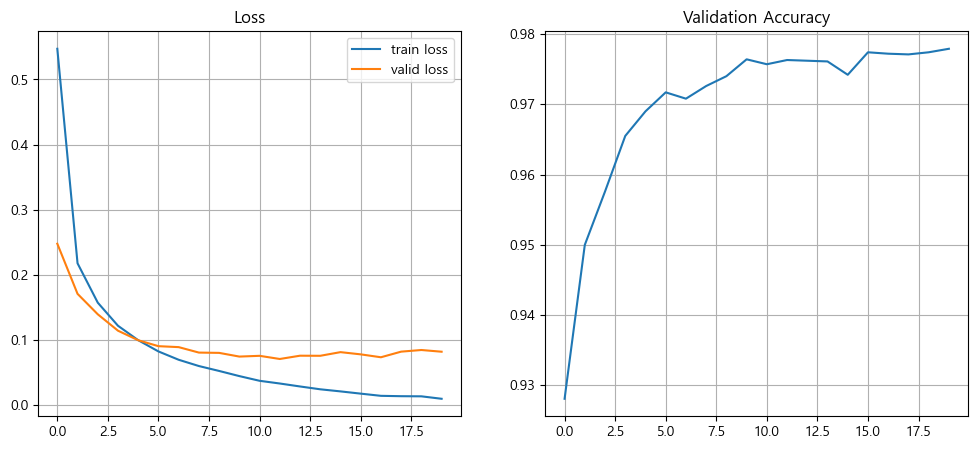

In [94]:
# epoch 별 loss/accuracy 변화를 시각화.
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_list, label="train loss")
plt.plot(range(epochs), val_loss_list, label="valid loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_acc_list)
plt.title("Validation Accuracy")
plt.grid(True)
plt.show()

### 학습된 모델 저장 및 불러오기

In [100]:
# pytorch 모델 저장 파일 확장자: pt, pth
saved_model_file_path = os.path.join(model_path, "mnist_mlp.pt")

In [102]:
#  model.state_dict()  # 모델을 구성하는 parameter 들을 조회 -> 저장
torch.save(model.state_dict(), saved_model_file_path)

In [103]:
##### 모델 불러오기 
# 모델 생성
load_model = MNISTModel()
# 생성한 모델의 파라미터를 저장할 파라미터로 변경.
load_parameter = torch.load(saved_model_file_path)
load_model.load_state_dict(load_parameter)

<All keys matched successfully>

## 모델 성능 최종 평가

In [105]:
load_model = load_model.to(device)
load_model.eval() #평가 모드로 변경.
test_loss, test_acc = 0.0, 0.0

with torch.no_grad():
    for X_test, y_test in test_loader:
        # 1. device 이동
        X_test, y_test = X_test.to(device), y_test.to(device)
        # 2. 모델 추정
        pred_test = load_model(X_test)
        # 3. 검증 - loss, acc
        test_loss += loss_fn(pred_test, y_test).item()
        ## class별 확률 -> class
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc += torch.sum(pred_test_class == y_test).item()
    # test_loss, test_acc 평균
    test_loss /= len(test_loader) # step수로 나눠서 평균계산
    test_acc /= len(test_loader.dataset) # 총 데이터 개수로 나눠서 평균계산

In [106]:
print(test_loss)
print(test_acc)

0.08226011931838002
0.9779


## 새로운 데이터 추론

In [107]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)


In [108]:
import cv2

In [129]:
def pred(model, device="cpu", *path):
    """model을 이용해서 *path의 이미지를 추론"""
    # 이미지 로딩
    ## 로딩된 이미지들을 저장할 tensor
    input_tensor = torch.zeros(len(path), 1, 28, 28)
    for i in range(len(path)):
        img = cv2.imread(path[i], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))
        input_tensor[i] = transforms.ToTensor()(img)
    # print("input data shape:", input_tensor.shape)
    # 추론
    model = model.to(device)
    model.eval()  #evaluation 모드 변환.
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        y_hat = model(input_tensor)
        y_hat_label = y_hat.argmax(dim=-1)
    return y_hat_label

In [136]:
from glob import glob

test_img_list = glob("test_img/num/*.png")
pred_result = pred(load_model, device, *test_img_list)
pred_result

tensor([6, 3, 5, 4, 0, 7, 3, 3, 3, 2, 2])

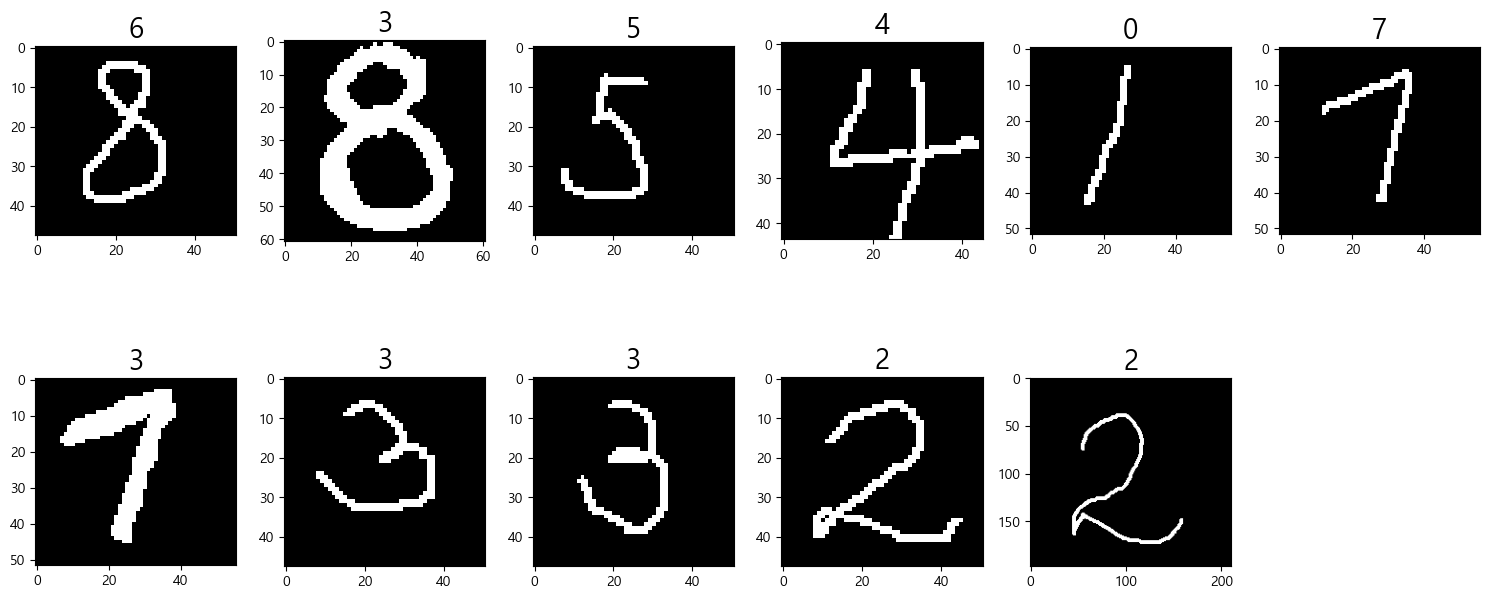

In [138]:
# 이미지 - 출력 결과 시각화
plt.figure(figsize=(15, 7))
for  idx, (path, label) in enumerate(zip(test_img_list, pred_result)):
    # print(idx, path, label.item())
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 6, idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(str(label.item()), fontsize=20)

plt.tight_layout()
plt.show()